# semantic, polysemy, frequency of words

use colab GPU for caculation (because my computer is really slow for one cpu and more cpu will kill the kernel).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import os
import gc
import psutil
from pathlib import Path
from tempfile import mkdtemp
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
from datetime import datetime
import torch 

### get semantic change rate	and log frequency (log of word count)

In [ ]:

# ================== 全局配置 ==================
MODEL_PATHS = [
    "/content/drive/MyDrive/c1t_word2vec.model",  # use Google Drive path
    "/content/drive/MyDrive/c2t_word2vec.model",
    "/content/drive/MyDrive/c3t_word2vec.model"
]
OUTPUT_DIR = Path("/content/drive/MyDrive/Colab Outputs")  # 改为可写目录
# ==============================================

MIN_FREQ = 0
VECTOR_SIZE = 100
N_CORES = cpu_count()//2  # 自动获取核心数[6](@ref)
BATCH_SIZE = 300  # 调整批次大小（Colab内存更大）
MMAP_DIR = mkdtemp(dir='/content')  # 指定临时目录[6](@ref)

# ================== 初始化函数 ==================
def init_worker():
    """替代lambda的可序列化初始化函数"""
    print(f"⚡ 子进程{os.getpid()}启动")

# ================== 内存映射处理 ==================
def create_memmaps(common_words, kvs):
    """创建内存映射文件并填充数据"""
    total_words = len(common_words)
    word_to_idx = {w: i for i, w in enumerate(common_words)}
    
    # 初始化内存映射
    memmap_files = []
    for period in range(3):
        mmap_path = os.path.join(MMAP_DIR, f'vectors_{period}.dat')
        fp = np.memmap(mmap_path, dtype=np.float32, mode='w+',
                      shape=(total_words, VECTOR_SIZE))
        
        # 填充数据
        for i, w in enumerate(common_words):
            fp[i] = kvs[period][w]
        fp.flush()
        memmap_files.append(fp)
    
    return memmap_files, word_to_idx

# ================== 批处理函数 ==================
def process_batch(args):
    """处理一批词汇"""
    batch_start, batch_end = args
    results = []
    
    try:
        # 加载内存映射
        memmaps = [
            np.memmap(os.path.join(MMAP_DIR, f'vectors_{period}.dat'),
                     dtype=np.float32, mode='r',
                     shape=(TOTAL_WORDS, VECTOR_SIZE))
            for period in range(3)
        ]
        
        # 词频统计 （获取每个词在不同时间段中的出现频率，并对所有时间段的频率求和，得到每个词的总频率
        kvs_counts = {w: sum(kv.get_vecattr(w, 'count') for kv in KVS_CACHE) 
                     for w in COMMON_WORDS_CACHE}

        for idx in range(batch_start, batch_end):
            word = COMMON_WORDS_CACHE[idx]
            
            # 语义变化计算 （计算1-2和2-3时间段的词向量余弦相似度，得到2个语义变化值，相加得到总的语义变化值
            vec0 = memmaps[0][idx]
            vec1 = memmaps[1][idx]
            vec2 = memmaps[2][idx]
            
            sim1 = cosine_similarity([vec0], [vec1])[0][0]
            sim2 = cosine_similarity([vec1], [vec2])[0][0]
            delta = (1 - sim1) + (1 - sim2)

            results.append({
                'word': word,
                'semantic_change': delta,
                'log_frequency': np.log10(kvs_counts.get(word, 0) + 1)
            })
            
    except Exception as e:
        print(f"批处理错误: {str(e)}")
    
    return results

# ================== 主程序 ==================
if __name__ == "__main__":
    global TOTAL_WORDS, COMMON_WORDS_CACHE, KVS_CACHE

    # ================ 修改点2：环境验证 ================
    print("👉 当前GPU加速状态：", torch.cuda.is_available())  # 验证GPU状态[2](@ref)
    
    # 初始化环境
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"🔄 临时文件存储在: {MMAP_DIR}")

    # 加载模型
    print("🔧 加载模型中...")
    try:
        models = [Word2Vec.load(p) for p in MODEL_PATHS]
        KVS_CACHE = [m.wv for m in models]
        print(f"模型验证: 的 -> {KVS_CACHE[0]['的'][:5]}")
    except Exception as e:
        print(f"加载失败: {str(e)}")
        exit()

    # 获取公共词汇
    print("🔍 计算公共词汇...")
    COMMON_WORDS_CACHE = list(set.intersection(*[set(kv.key_to_index) for kv in KVS_CACHE]))
    print(f"✅ 有效词汇量: {len(COMMON_WORDS_CACHE)}")

    # 创建内存映射
    print("💾 创建内存映射...")
    memmap_files, word_to_idx = create_memmaps(COMMON_WORDS_CACHE, KVS_CACHE)
    del models
    gc.collect()

    # 准备批处理任务
    TOTAL_WORDS = len(COMMON_WORDS_CACHE)
    batches = [
        (i, min(i+BATCH_SIZE, TOTAL_WORDS))
        for i in range(0, TOTAL_WORDS, BATCH_SIZE)
    ]
    print(f"📦 共生成{len(batches)}个处理批次")

    # 并行处理
    print(f"🚀 启动{N_CORES}个进程...")
    start_time = datetime.now()
    
    with Pool(processes=N_CORES, initializer=init_worker) as pool:
        results = []
        with tqdm(total=len(batches), desc="处理进度") as pbar:
            for batch_res in pool.imap_unordered(process_batch, batches):
                results.extend(batch_res)
                pbar.update()
                pbar.set_postfix({
                    "速率": f"{len(results)/max(1,(datetime.now()-start_time).seconds)}词/秒",
                    "内存": f"{psutil.Process().memory_info().rss//1024//1024}MB"
                })

    # 清理资源
    print("🧹 清理临时文件...")
    for f in os.listdir(MMAP_DIR):
        os.remove(os.path.join(MMAP_DIR, f))
    os.rmdir(MMAP_DIR)

    # 保存结果
    print("💾 保存结果...")
    pd.DataFrame(results).to_csv(OUTPUT_DIR/"results.csv", index=False)
    print(f"✅ 完成! 耗时{(datetime.now()-start_time).total_seconds():.1f}秒")

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("C:\\Users\\huawei\\OneDrive\\桌面\\QTA final project\\results.csv")
data.head(2)

,word,semantic_change,cross_period_polysemy,log_frequency
0,关向东,2.276781,0.038886,0.778151
1,油馍,1.809787,0.270721,0.778151


In [ ]:
re = pd.read_csv("C:\\Users\\huawei\\OneDrive\\桌面\\QTA final project\\results.csv")
re.head(5)

,word,semantic_change,cross_period_polysemy,log_frequency
0,关向东,2.276781,0.038886,0.778151
1,油馍,1.809787,0.270721,0.778151
2,每加,1.957251,0.157378,0.845098
3,灭亡,1.967370,0.131044,3.521400
4,见于,2.093344,0.314521,2.243038


## use one CPU but only 20% words below （13 hours +）
（my free colab limit is used up in last section）
### get semantic change rate and polysemy index

In [ ]:
import numpy as np
import pandas as pd
import gc
import psutil
import random
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from tqdm.auto import tqdm

# ================== 全局配置 ==================
MODEL_PATHS = [
    "D:/CODE/data set for QTA/c1t_word2vec.model",
    "D:/CODE/data set for QTA/c2t_word2vec.model",
    "D:/CODE/data set for QTA/c3t_word2vec.model"
]
OUTPUT_DIR = Path(r"C:\Users\huawei\OneDrive\桌面\QTA final project")
MIN_FREQ = 0
VECTOR_SIZE = 100
TOP_NEIGHBORS = 20

# ================== 核心函数定义 ==================
def procrustes_align(base_kv, target_kv, common_words):
    """Procrustes对齐"""
    base_vecs = np.array([base_kv.get_vector(w) for w in common_words], dtype=np.float32)
    target_vecs = np.array([target_kv.get_vector(w) for w in common_words], dtype=np.float32)
    
    # 中心化处理
    base_mean = np.mean(base_vecs, axis=0)
    target_mean = np.mean(target_vecs, axis=0)
    base_vecs -= base_mean
    target_vecs -= target_mean
    
    # SVD分解
    M = target_vecs.T.dot(base_vecs)
    U, _, Vt = np.linalg.svd(M, full_matrices=False)
    R = U.dot(Vt)
    
    return {
        word: (target_kv.get_vector(word) - target_mean).dot(R) + base_mean
        for word in target_kv.key_to_index
    }

def compute_semantic_change(word, aligned_dicts):
    """语义变化计算"""
    try:
        vecs = [aligned_dicts[i][word] for i in range(3)]
        sim1 = cosine_similarity([vecs[0]], [vecs[1]])[0][0]
        sim2 = cosine_similarity([vecs[1]], [vecs[2]])[0][0]
        return (1 - sim1) + (1 - sim2)
    except KeyError:
        return np.nan

def compute_polysemy(word, aligned_dicts):
    """多义性计算"""
    try:
        polysemy_scores = []
        for period_dict in aligned_dicts:
            target_vec = period_dict[word]
            all_vecs = np.array(list(period_dict.values()), dtype=np.float32)
            
            sims = cosine_similarity([target_vec], all_vecs)[0]
            top_indices = np.argpartition(-sims, TOP_NEIGHBORS+1)[1:TOP_NEIGHBORS+1]
            neighbors = all_vecs[top_indices]
            
            neighbor_sims = cosine_similarity(neighbors)
            np.fill_diagonal(neighbor_sims, np.nan)
            polysemy_scores.append(np.nanstd(neighbor_sims))
        
        avg_score = np.nanmean(polysemy_scores)
        variation = np.nanstd(polysemy_scores) / (avg_score + 1e-8)
        return avg_score * (1 + variation)
    except Exception as e:
        return np.nan

# ================== 主程序 ==================
if __name__ == "__main__":
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # 模型加载
    print("🔄 加载模型中...")
    try:
        models = [Word2Vec.load(p) for p in MODEL_PATHS]
        kvs = [m.wv for m in models]
        print(f"模型验证: 的 -> 词频={kvs[0].get_vecattr('的', 'count')}, 向量={kvs[0]['的'][:5]}")
    except Exception as e:
        print(f"模型加载失败: {str(e)}")
        exit()

    # 公共词汇筛选
    print("🔍 筛选公共词汇...")
    common_words = set(kvs[0].key_to_index)
    for kv in kvs[1:]:
        common_words.intersection_update(kv.key_to_index)
    print(f"初步公共词汇量: {len(common_words)}")
    
    # 词频过滤
    valid_words = []
    for w in tqdm(common_words, desc="词频过滤"):
        try:
            total = sum(kv.get_vecattr(w, 'count') for kv in kvs if w in kv)
            if total >= MIN_FREQ:
                valid_words.append(w)
        except Exception as e:
            print(f"词频错误 [{w}]: {str(e)}")
    common_words = valid_words
    print(f"✅ 有效词汇量: {len(common_words)} (示例: {common_words[:5]})")
    
    # 随机抽取25%词汇（修改点1）
    selected_words = random.sample(common_words, k=int(len(common_words)*0.2))
    print(f"🎯 随机选择 {len(selected_words)} 个词进行处理（占总词汇量的20%）")

    # 向量对齐
    print("🧩 对齐向量空间...")
    try:
        aligned_dicts = [
            {w: kvs[0].get_vector(w) for w in common_words},
            procrustes_align(kvs[0], kvs[1], common_words),
            procrustes_align(kvs[0], kvs[2], common_words)
        ]
        test_word = selected_words[0]
        print(f"对齐验证 [{test_word}]:")
        print("时期1:", aligned_dicts[0][test_word][:5])
        print("时期2:", aligned_dicts[1][test_word][:5])
    except Exception as e:
        print(f"对齐失败: {str(e)}")
        exit()

    # 数据处理（修改点2）
    print("🚀 开始处理...")
    results = []
    for word in tqdm(selected_words, desc="处理进度"):
        try:
            delta = compute_semantic_change(word, aligned_dicts)
            if np.isnan(delta):
                continue
                
            polysemy = compute_polysemy(word, aligned_dicts)
            if np.isnan(polysemy):
                continue
                
            results.append({
                'word': word,
                'cross_period_polysemy': np.log1p(polysemy),  # 保留多义性
                'semantic_change': delta  # 保留语义变化
            })
            
        except Exception as e:
            continue

    # 保存结果（修改点3）
    output_path = OUTPUT_DIR / "PS.csv"
    pd.DataFrame(results).to_csv(output_path, index=False, encoding='utf-8')
    print(f"保存结果: {len(results)}条数据 -> {output_path}")

## draw the graph

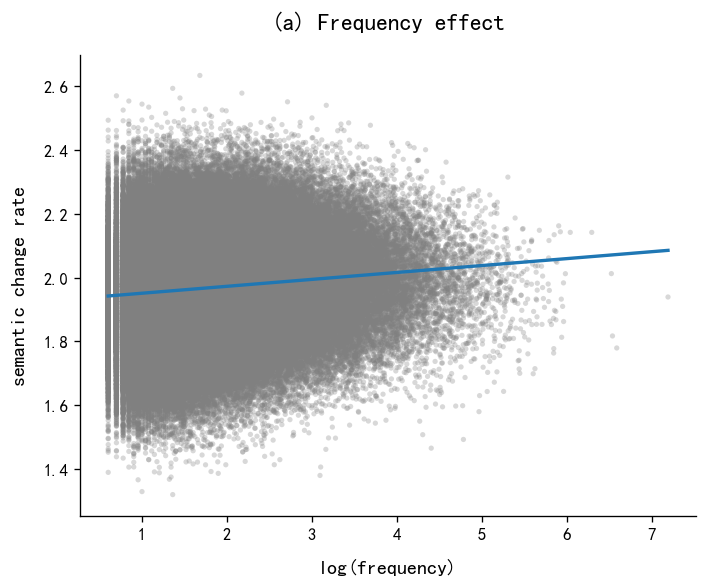

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 re 是你的数据集，包含 log_frequency 和 semantic_change 列
# 示例：读取数据集（请替换为实际文件路径）
re = pd.read_csv("C:\\Users\\huawei\\OneDrive\\桌面\\QTA final project\\results.csv")

# ========== 词频效应子图 ==========
plt.figure(figsize=(6, 5), dpi=120)
sns.regplot(
    x='log_frequency', y='semantic_change', data=re,
    scatter_kws={
        's': 10,               # 缩小点尺寸
        'alpha': 0.3,          # 增加透明度
        'color': '#808080',    # 灰色散点
        'edgecolor': 'none'    # 去除边缘线
    },
    line_kws={
        'color': '#1f77b4',    # 蓝色回归线
        'lw': 2.0              # 增加线宽
    },
)

# 坐标轴设置
plt.xlabel("log(frequency)", fontsize=12, labelpad=10)
plt.ylabel("semantic change rate", fontsize=12, labelpad=10)
plt.title("(a) Frequency effect", fontsize=14, pad=15)


# 显示图像
plt.tight_layout()
plt.show()


In [21]:
ps = pd.read_csv("C:\\Users\\huawei\\OneDrive\\桌面\\QTA final project\\PS.csv")
ps.head(5)

,word,cross_period_polysemy,semantic_change
0,非常适合,0.116525,1.238642
1,出血点,0.109713,1.174115
2,康世恩,0.108023,1.137038
3,酣,0.128295,1.324869
4,筐子,0.091005,0.887811


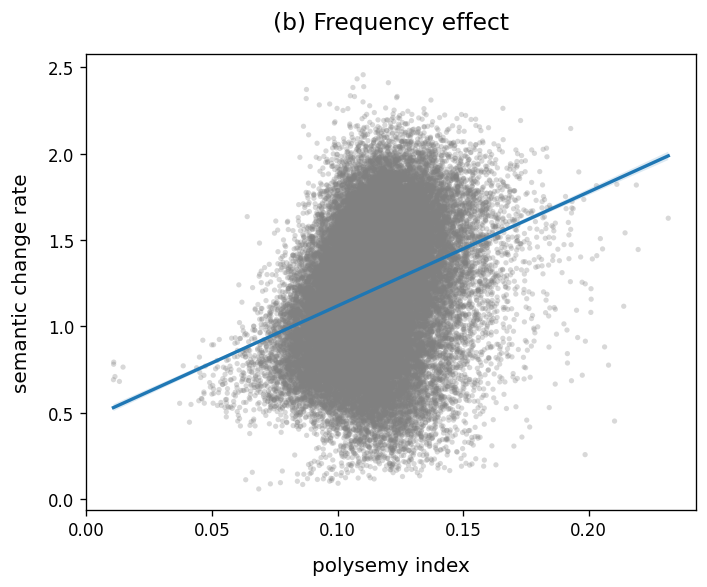

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 re 是你的数据集，包含 log_frequency 和 semantic_change 列
# 示例：读取数据集（请替换为实际文件路径）
ps = pd.read_csv("C:\\Users\\huawei\\OneDrive\\桌面\\QTA final project\\PS.csv")

# ========== 词频效应子图 ==========
plt.figure(figsize=(6, 5), dpi=120)
sns.regplot(
    x='cross_period_polysemy', y='semantic_change', data=ps,
    scatter_kws={
        's': 10,               # 缩小点尺寸
        'alpha': 0.3,          # 增加透明度
        'color': '#808080',    # 灰色散点
        'edgecolor': 'none'    # 去除边缘线
    },
    line_kws={
        'color': '#1f77b4',    # 蓝色回归线
        'lw': 2.0              # 增加线宽
    },
    robust=True
)

# 坐标轴设置
plt.xlabel("polysemy index", fontsize=12, labelpad=10)
plt.ylabel("semantic change rate", fontsize=12, labelpad=10)
plt.title("(b) Frequency effect", fontsize=14, pad=15)


# 显示图像
plt.tight_layout()
plt.show()


### only use one CPU for all words （60 hours to run, so ...）

In [4]:
import numpy as np
import pandas as pd
import gc
import psutil
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from tqdm.auto import tqdm

# ================== 全局配置 ==================
MODEL_PATHS = [
    "D:/CODE/data set for QTA/c1t_word2vec.model",
    "D:/CODE/data set for QTA/c2t_word2vec.model",
    "D:/CODE/data set for QTA/c3t_word2vec.model"
]
OUTPUT_DIR = Path(r"C:\Users\huawei\OneDrive\桌面\QTA final project")
MIN_FREQ = 5
VECTOR_SIZE = 100
TOP_NEIGHBORS = 20

# ================== 核心函数定义 ==================
def procrustes_align(base_kv, target_kv, common_words):
    """Procrustes对齐"""
    base_vecs = np.array([base_kv.get_vector(w) for w in common_words], dtype=np.float32)
    target_vecs = np.array([target_kv.get_vector(w) for w in common_words], dtype=np.float32)
    
    # 中心化处理
    base_mean = np.mean(base_vecs, axis=0)
    target_mean = np.mean(target_vecs, axis=0)
    base_vecs -= base_mean
    target_vecs -= target_mean
    
    # SVD分解
    M = target_vecs.T.dot(base_vecs)
    U, _, Vt = np.linalg.svd(M, full_matrices=False)
    R = U.dot(Vt)
    
    return {
        word: (target_kv.get_vector(word) - target_mean).dot(R) + base_mean
        for word in target_kv.key_to_index
    }

def compute_semantic_change(word, aligned_dicts):
    """语义变化计算"""
    try:
        vecs = [aligned_dicts[i][word] for i in range(3)]
        sim1 = cosine_similarity([vecs[0]], [vecs[1]])[0][0]
        sim2 = cosine_similarity([vecs[1]], [vecs[2]])[0][0]
        return (1 - sim1) + (1 - sim2)
    except KeyError:
        return np.nan

def compute_polysemy(word, aligned_dicts):
    """多义性计算"""
    try:
        polysemy_scores = []
        for period_dict in aligned_dicts:
            # 获取目标词向量
            target_vec = period_dict[word]
            all_vecs = np.array(list(period_dict.values()), dtype=np.float32)
            
            # 批量计算相似度
            sims = cosine_similarity([target_vec], all_vecs)[0]
            
            # 获取TopN邻居（排除自身）
            top_indices = np.argpartition(-sims, TOP_NEIGHBORS+1)[1:TOP_NEIGHBORS+1]
            neighbors = all_vecs[top_indices]
            
            # 计算邻居间相似度的标准差
            neighbor_sims = cosine_similarity(neighbors)
            np.fill_diagonal(neighbor_sims, np.nan)
            polysemy_scores.append(np.nanstd(neighbor_sims))
        
        # 综合指标：标准差均值 × 波动系数
        avg_score = np.nanmean(polysemy_scores)
        variation = np.nanstd(polysemy_scores) / (avg_score + 1e-8)
        return avg_score * (1 + variation)
    except Exception as e:
        return np.nan

# ... [保持原有导入和配置不变] ...

# ================== 主程序调试版 ==================
if __name__ == "__main__":
    # 初始化环境
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # 加载模型并验证
    print("🔄 加载模型中...")
    try:
        models = [Word2Vec.load(p) for p in MODEL_PATHS]
        kvs = [m.wv for m in models]
        print(f"模型验证: 的 -> 词频={kvs[0].get_vecattr('的', 'count')}, 向量={kvs[0]['的'][:5]}")
    except Exception as e:
        print(f"模型加载失败: {str(e)}")
        exit()

    # 计算公共词汇
    print("🔍 筛选公共词汇...")
    common_words = set(kvs[0].key_to_index)
    for kv in kvs[1:]:
        common_words.intersection_update(kv.key_to_index)
    print(f"初步公共词汇量: {len(common_words)}")
    
    # 词频过滤调试
    valid_words = []
    for w in tqdm(common_words, desc="词频过滤"):
        try:
            total = sum(kv.get_vecattr(w, 'count') for kv in kvs if w in kv)
            if total >= MIN_FREQ:
                valid_words.append(w)
        except Exception as e:
            print(f"词频错误 [{w}]: {str(e)}")
    common_words = valid_words
    print(f"✅ 有效词汇量: {len(common_words)} (示例: {common_words[:5]})")
    
    # 向量对齐调试
    print("🧩 对齐向量空间...")
    try:
        aligned_dicts = [
            {w: kvs[0].get_vector(w) for w in common_words},
            procrustes_align(kvs[0], kvs[1], common_words),
            procrustes_align(kvs[0], kvs[2], common_words)
        ]
        test_word = common_words[0]
        print(f"对齐验证 [{test_word}]:")
        print("时期1:", aligned_dicts[0][test_word][:5])
        print("时期2:", aligned_dicts[1][test_word][:5])
    except Exception as e:
        print(f"对齐失败: {str(e)}")
        exit()

    # 单线程处理调试
    print("🚀 开始处理...")
    results = []
    for word in tqdm(common_words, desc="处理进度"):
        try:
            # 语义变化
            delta = compute_semantic_change(word, aligned_dicts)
            if np.isnan(delta):
                print(f"跳过 [{word}]: 无效的语义变化值")
                continue
                
            # 词频
            total_freq = sum(kv.get_vecattr(w, 'count') for kv in kvs if w in kv)
            
            # 多义性
            polysemy = compute_polysemy(word, aligned_dicts)
            if np.isnan(polysemy):
                print(f"跳过 [{word}]: 无效的多义性值")
                continue
                
            results.append({
                'word': word,
                'log_frequency': np.log10(total_freq + 1),
                'cross_period_polysemy': np.log1p(polysemy),
                'semantic_change': delta
            })
            
        except Exception as e:
            print(f"处理失败 [{word}]: {str(e)}")
            continue

    # 保存结果
    output_path = OUTPUT_DIR / "semantic_change_data.csv"
    pd.DataFrame(results).to_csv(output_path, index=False, encoding='utf-8')
    print(f"保存结果: {len(results)}条数据")

🔄 加载模型中...
模型验证: 的 -> 词频=8402886, 向量=[-2.2897217   0.6709739   0.39929917  0.86414516 -0.09695255]
🔍 筛选公共词汇...
初步公共词汇量: 217612


词频过滤:   0%|          | 0/217612 [00:00<?, ?it/s]

✅ 有效词汇量: 208485 (示例: ['洪性', '寒意', '省时省力', '邹德华', '显好'])
🧩 对齐向量空间...
对齐验证 [洪性]:
时期1: [-0.71077335 -0.05628807 -0.19081314 -0.22118163 -0.37716907]
时期2: [-0.11587086  0.30459696 -0.0827805  -0.01378869  0.18334231]
🚀 开始处理...


处理进度:   0%|          | 0/208485 [00:00<?, ?it/s]

KeyboardInterrupt: 